## Load Experiment Data

In [1]:
# Load the policy
import os
import pandas
from garage.experiment import Snapshotter
import pandas as pd
EXPERIMENT_NAME = "CL_point_env" #13

experiment_dir = os.path.join("data/local/experiment", EXPERIMENT_NAME)
snapshotter = Snapshotter()
data = snapshotter.load(experiment_dir)
policy = data['algo'].policy
experiment_data_path = os.path.join(experiment_dir, "experiment.json")
experiment_data = pandas.read_json(experiment_data_path)

# You can also access other components of the experiment
env = data['env']

progress_csv_path = os.path.join(experiment_dir, 'progress.csv')
# progress_df = pd.read_csv(progress_csv_path)

2025-01-17 14:22:37.013211: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.




Failed to import TF-Keras. Please note that TF-Keras is not installed by default when you install TensorFlow Probability. This is so that JAX-only users do not have to install TensorFlow or TF-Keras. To use TensorFlow Probability with TensorFlow, please install the tf-keras or tf-keras-nightly package.
This can be be done through installing the tensorflow-probability[tf] extra.




/Users/paulnitschke/Desktop/projects/geo_meta_rl/garage/experiment/deterministic.py:36: UserWarning: Enabeling deterministic mode in PyTorch can have a performance impact when using GPU.
  warnings.warn(


In [6]:
num_train_tasks=2
import torch
from garage.experiment.task_sampler import SetTaskSampler
from garage.envs import GymEnv, normalize
from garage.envs.point_env import PointEnv
from garage.torch.algos.CLMeta import PEARLWorker

worker_args = dict(deterministic=True, accum_context=True)
env_sampler = SetTaskSampler(
    PointEnv,
    wrapper=lambda env, _: normalize(
        env))
env = env_sampler.sample(num_train_tasks)

def _map_task_index_to_embedding(_env, idx):
    """Map task index to ground-truth embeddings. Only valid for Point Environment."""
    return torch.tensor(_env[idx]._make_env().reset()[1]["goal"], dtype=torch.float32)

_envidx_to_embeddings = {}
for idx_env, _ in enumerate(env):
    _envidx_to_embeddings[idx_env] = _map_task_index_to_embedding(env, idx_env)
hard_coded_embeddings=[emb.unsqueeze(0) for emb in list(_envidx_to_embeddings.values())]

In [3]:
from garage.experiment.meta_evaluator import MetaEvaluator

meta_evaluator = MetaEvaluator(test_tasks=env,
                               worker_class=PEARLWorker,
                               worker_args=worker_args,
                               n_exploration_eps=10,
                               n_test_tasks=2,
                               return_task_embeddings=True,
                               hard_coded_embeddings=hard_coded_embeddings,
                               log_wandb=False)

trajs, task_embeddings = meta_evaluator.evaluate(algo=data['algo'])

/Users/paulnitschke/Desktop/projects/geo_meta_rl/garage/experiment/meta_evaluator.py:98: LoggerWarning: No outputs have been added to the logger.
  logger.log('Sampling for adapation and meta-testing...')
/Users/paulnitschke/Desktop/projects/geo_meta_rl/garage/experiment/meta_evaluator.py:98: LoggerWarning: Log data of type str was not accepted by any output
  logger.log('Sampling for adapation and meta-testing...')
/Users/paulnitschke/Desktop/projects/geo_meta_rl/garage/experiment/deterministic.py:36: UserWarning: Enabeling deterministic mode in PyTorch can have a performance impact when using GPU.
  warnings.warn(
/Users/paulnitschke/miniconda3/envs/env_geo_meta_rl/lib/python3.9/site-packages/torch/distributions/distribution.py:53: UserWarning: <class 'garage.torch.distributions.tanh_normal.TanhNormal'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(
/Users/paulnits



Failed to import TF-Keras. Please note that TF-Keras is not installed by default when you install TensorFlow Probability. This is so that JAX-only users do not have to install TensorFlow or TF-Keras. To use TensorFlow Probability with TensorFlow, please install the tf-keras or tf-keras-nightly package.
This can be be done through installing the tensorflow-probability[tf] extra.




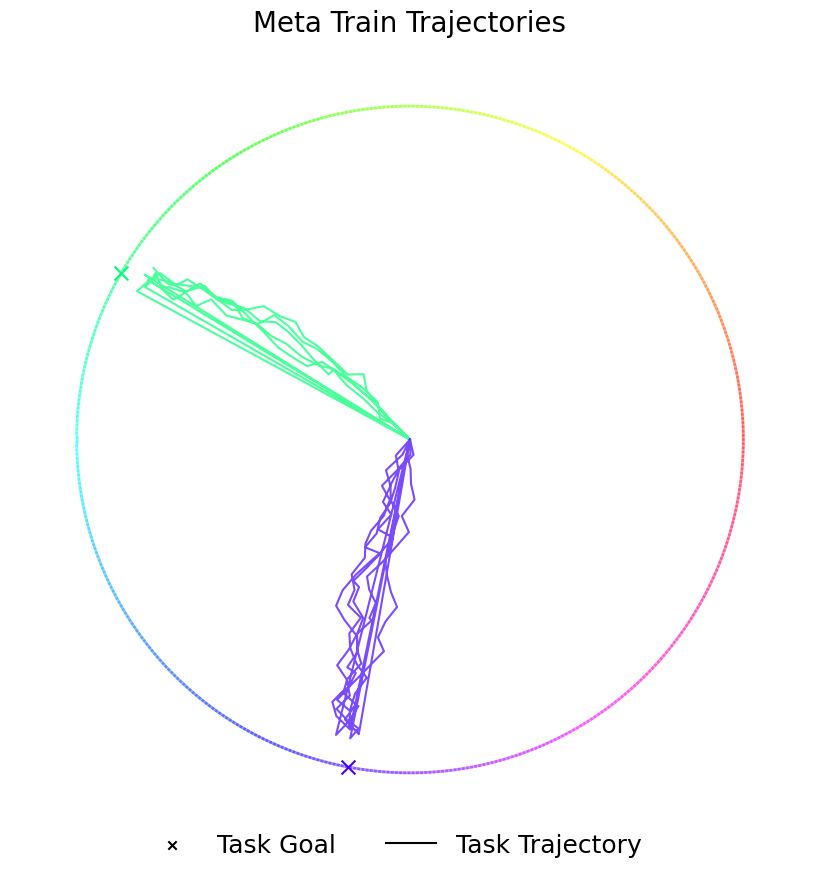

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

def plot_trajs_on_circle(trajs, marker_trajs, title):
    # Create a colormap and normalizer
    cmap = plt.cm.hsv  # Use the hsv colormap
    norm = Normalize(vmin=0, vmax=2 * np.pi)

    # Generate points for the circle
    angles = np.linspace(0, 2 * np.pi, 500)
    x_circle = 2 * np.cos(angles)
    y_circle = 2 * np.sin(angles)

    # Create the figure and axis
    fig = plt.figure(figsize=(12, 12))  # Increase figure size for wider space around the circle
    ax = fig.add_subplot(111)

    # Set the fixed size for the circle area (8x8 inches)
    circle_size_inches = 8
    fig_width, fig_height = fig.get_size_inches()

    # Calculate the position for the circle to take up exactly 8x8 inches
    left_margin = (fig_width - circle_size_inches) / 2 / fig_width
    bottom_margin = (fig_height - circle_size_inches) / 2 / fig_height
    ax_width = circle_size_inches / fig_width
    ax_height = circle_size_inches / fig_height

    ax.set_position([left_margin, bottom_margin, ax_width, ax_height])  # Adjust axis position

    # Set fixed aspect ratio and limits
    ax.set_aspect('equal', adjustable='box')
    circle_radius = 2
    ax.set_xlim(-circle_radius * 1.2, circle_radius * 1.2)  # Add more padding around the circle
    ax.set_ylim(-circle_radius * 1.2, circle_radius * 1.2)  # Add more padding around the circle

    # Add grid in the background
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')

    # Plot the circle with continuous color
    for i in range(len(angles) - 1):
        ax.plot(x_circle[i:i + 2], y_circle[i:i + 2], color=cmap(norm(angles[i])), linewidth=2, alpha=0.4)

    # Plot trajectories
    for task_traj in trajs:
        goal_x, goal_y = task_traj.env_infos["task"][0]["goal"]
        goal_angle = (np.arctan2(goal_y, goal_x) + 2 * np.pi) % (2 * np.pi)

        goal_color = cmap(norm(goal_angle))
        ax.plot(task_traj.observations[:, 0], task_traj.observations[:, 1], c=goal_color, alpha=0.7)

    # Plot markers for task goals
    for marker_traj in marker_trajs:
        goal_x, goal_y = marker_traj.env_infos["task"][0]["goal"]
        goal_angle = (np.arctan2(goal_y, goal_x) + 2 * np.pi) % (2 * np.pi)

        goal_color = cmap(norm(goal_angle))
        ax.scatter(goal_x, goal_y, color=goal_color, marker='x', s=100)

    ax.scatter([], [], color='black', marker='x', label='Task Goal')
    ax.plot([], [], color='black', label='Task Trajectory')

    # Turn off the axis
    ax.axis('off')

    # Add title
    plt.title(title, fontsize=20)
    ax.legend(ncol=2, loc='lower center', bbox_to_anchor=(0.48, -0.05), frameon=False, fontsize=18)
    # Save the plot
    plt.show()



plot_trajs_on_circle(trajs, trajs, "Meta Train Trajectories")

# Generalization Performance

In [9]:
num_test_tasks=25

worker_args = dict(deterministic=True, accum_context=True)
env_sampler = SetTaskSampler(
    PointEnv,
    wrapper=lambda env, _: normalize(
        env))
test_envs = env_sampler.sample(num_test_tasks)
_testenvidx_to_embeddings = {}
for idx_env, _ in enumerate(test_envs):
    _testenvidx_to_embeddings[idx_env] = _map_task_index_to_embedding(test_envs, idx_env)
test_hard_coded_embeddings=[emb.unsqueeze(0) for emb in list(_testenvidx_to_embeddings.values())]

meta_evaluator = MetaEvaluator(test_tasks=test_envs,
                               worker_class=PEARLWorker,
                               worker_args=worker_args,
                               n_exploration_eps=10,
                               n_test_tasks=5,
                               return_task_embeddings=True,
                                 hard_coded_embeddings=test_hard_coded_embeddings,
                               log_wandb=False)

test_trajs, test_task_embeddings = meta_evaluator.evaluate(algo=data['algo'])



Failed to import TF-Keras. Please note that TF-Keras is not installed by default when you install TensorFlow Probability. This is so that JAX-only users do not have to install TensorFlow or TF-Keras. To use TensorFlow Probability with TensorFlow, please install the tf-keras or tf-keras-nightly package.
This can be be done through installing the tensorflow-probability[tf] extra.




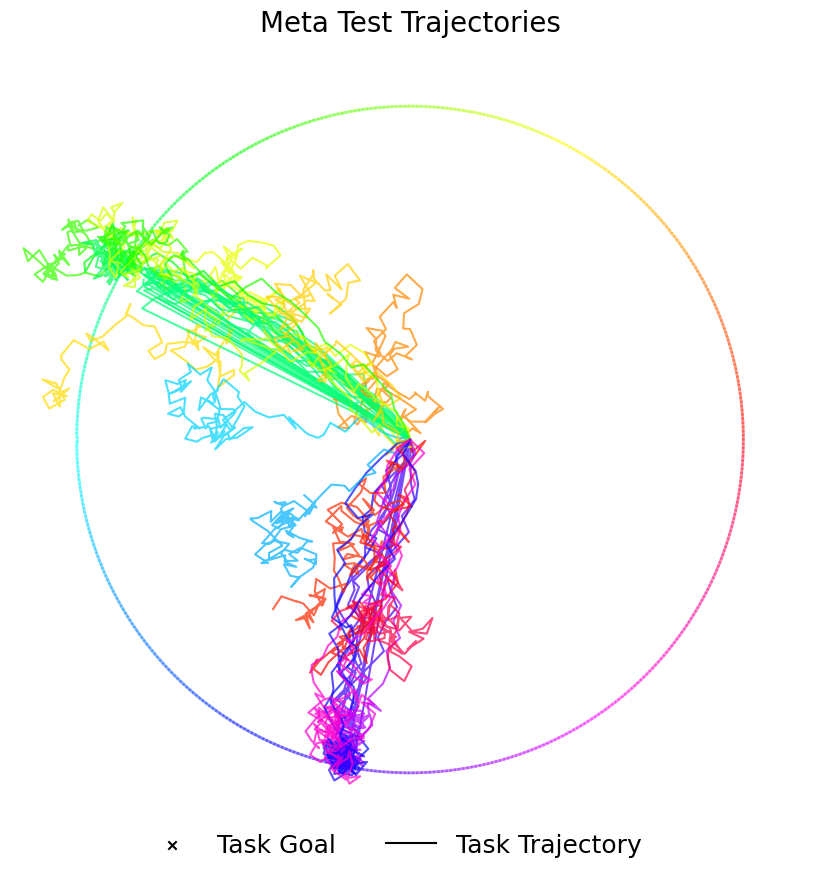

In [18]:
plot_trajs_on_circle(test_trajs, trajs, "Meta Test Trajectories")


# How well do test-tasks do with correct, hard-coded embedding?

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

def rotate_point(p, angle):
    """
    Rotates a point on the unit circle by a given angle.

    Parameters:
    - p: numpy array of shape (2,), coordinates of the point on the unit circle.
    - angle: float, the angle in radians to rotate the point.

    Returns:
    - rotated_p: numpy array of shape (2,), the rotated point coordinates.
    """
    # Rotation matrix
    rotation_matrix = np.array([
        [np.cos(angle), -np.sin(angle)],
        [np.sin(angle), np.cos(angle)]
    ])

    # Apply the rotation matrix
    rotated_p = np.dot(rotation_matrix, p)

    return rotated_p

def plot_trajs_and_embeddings_on_circle_normalized(marker_trajs, trajs_embeddings, 
                                                   task_embeddings,
                                                   title,
                                                   reverse_embedding_colors=True,
                                                   rotation_angle=0
                                                   ):
    # Create a colormap and normalizer
    cmap = plt.cm.hsv  # Use the hsv colormap
    norm = Normalize(vmin=0, vmax=2 * np.pi)

    # Generate points for the circle
    angles = np.linspace(0, 2 * np.pi, 500)
    x_circle = 2 * np.cos(angles)
    y_circle = 2 * np.sin(angles)

    # Create the figure and axis
    fig = plt.figure(figsize=(12, 12))  # Increase figure size for wider space around the circle
    ax = fig.add_subplot(111)

    # Set the fixed size for the circle area (8x8 inches)
    circle_size_inches = 8
    fig_width, fig_height = fig.get_size_inches()

    # Calculate the position for the circle to take up exactly 8x8 inches
    left_margin = (fig_width - circle_size_inches) / 2 / fig_width
    bottom_margin = (fig_height - circle_size_inches) / 2 / fig_height
    ax_width = circle_size_inches / fig_width
    ax_height = circle_size_inches / fig_height

    ax.set_position([left_margin, bottom_margin, ax_width, ax_height])  # Adjust axis position

    # Set fixed aspect ratio and limits
    ax.set_aspect('equal', adjustable='box')
    circle_radius = 2
    ax.set_xlim(-circle_radius * 1.2, circle_radius * 1.2)  # Add more padding around the circle
    ax.set_ylim(-circle_radius * 1.2, circle_radius * 1.2)  # Add more padding around the circle

    # Add grid in the background
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')

    # Plot the circle with continuous color
    for i in range(len(angles) - 1):
        ax.plot(x_circle[i:i + 2], y_circle[i:i + 2], color=cmap(norm(angles[i])), linewidth=2, alpha=0.4)

    # Plot markers for task goals
    goal_colors_markers = []
    for marker_traj in marker_trajs:
        goal_x, goal_y = marker_traj.env_infos["task"][0]["goal"]
        goal_angle = (np.arctan2(goal_y, goal_x) + 2 * np.pi) % (2 * np.pi)

        goal_color = cmap(norm(goal_angle))
        ax.scatter(goal_x, goal_y, color=goal_color, marker='x', s=100)
        goal_colors_markers.append(goal_color)

    goal_colors_embeddings = []
    for idx, traj_embedding in enumerate(trajs_embeddings):
        goal_x, goal_y = traj_embedding.env_infos["task"][0]["goal"]
        goal_angle = (np.arctan2(goal_y, goal_x) + 2 * np.pi) % (2 * np.pi)
        goal_color = cmap(norm(goal_angle))
        goal_colors_embeddings.append(goal_color)

    if reverse_embedding_colors:
        goal_colors_embeddings = goal_colors_embeddings[::-1]
    for idx, task_embedding in enumerate(task_embeddings):
        if rotation_angle != 0:
            task_embedding = rotate_point(task_embedding[0], rotation_angle)
            task_embedding=[task_embedding]
        plt.quiver(
                0, 0, task_embedding[0][0], task_embedding[0][1], angles='xy', scale_units='xy', scale=0.5,
                color=goal_colors_embeddings[idx])

    ax.scatter([], [], color='black', marker='x', label='Task Goal')
    ax.plot([], [], color='black', label='Task Embedding')

    # Turn off the axis
    ax.axis('off')

    # Add title
    plt.title(title, fontsize=20)
    ax.legend(ncol=2, loc='lower center', bbox_to_anchor=(0.48, -0.05), frameon=False, fontsize=18)
    # Save the plot
    plt.show()

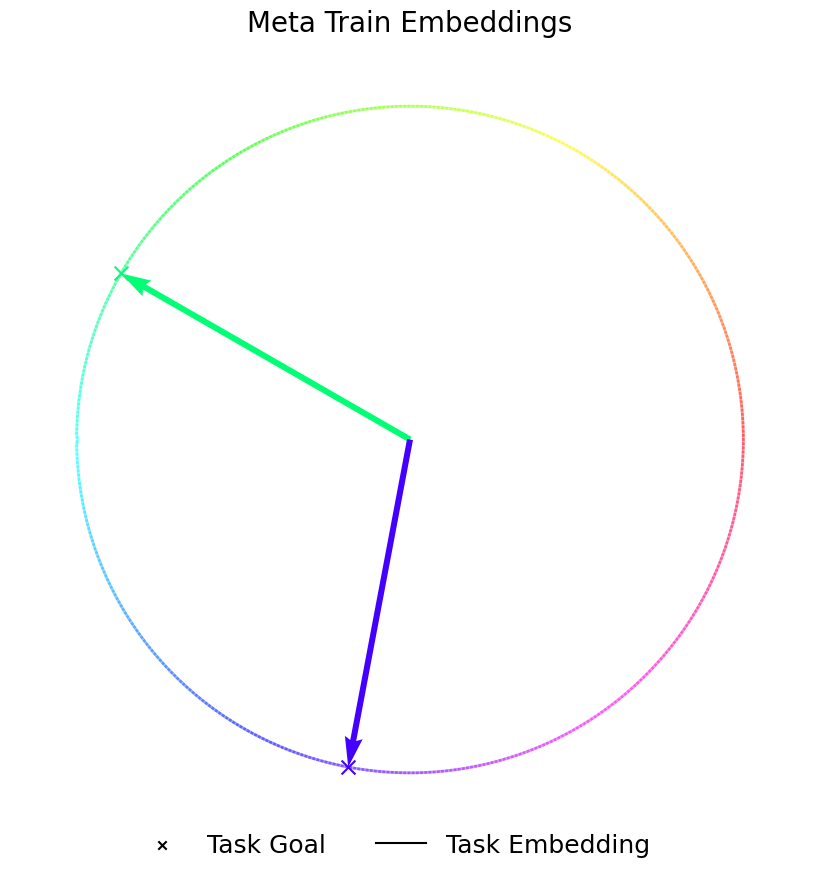

In [24]:
plot_trajs_and_embeddings_on_circle_normalized(marker_trajs=trajs, 
                                    trajs_embeddings=trajs,
                                    task_embeddings=task_embeddings,
                                    title="Meta Train Embeddings",
                                    reverse_embedding_colors=False,
                                    rotation_angle=0
                                    )

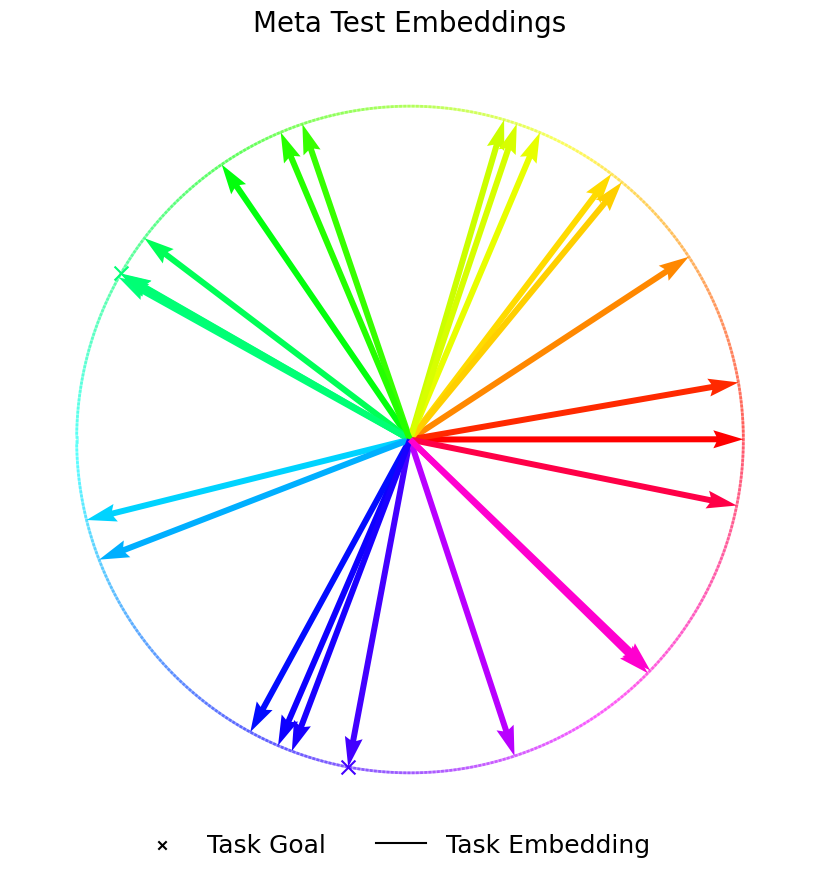

In [26]:
plot_trajs_and_embeddings_on_circle_normalized(marker_trajs=trajs, 
                                    trajs_embeddings=test_trajs,
                                    task_embeddings=test_task_embeddings,
                                    title="Meta Test Embeddings",
                                    reverse_embedding_colors=False,
                                    rotation_angle=0
                                    )